# Test code to read in & stitch GelSight scans of an object

This interactive notebook documents the gspython code for stitching together GelSight scans of a single object in more detail, and allows the user to test different functions.

### Requirements

built-in module `os`

built-in module `sys`

built-in module `heapq`

built-in module `random`

open source module `numpy`

open source module `scipy`

open source module `opencv`

open source module `matplotlib`

open source package `gspython` with modules `readscan` and `readtmd`

### Functions

`readdata`

## Detailed description

### Comparison to built-in cv.Stitcher class

## Running the code

First, we import the dependencies:

In [3]:
import os
import sys
import heapq
import numpy as np
import scipy
import random
import cv2 as cv
from matplotlib import pyplot as plt

sys.path.append(r"../")
import readscan
import readtmd

### Testing functions

Next, we define and test the necessary functions.

In [33]:
def readdata(parent,allowance=10,normalize_height=True):
    scans = []
    hdata = {}
    hmaps = []
    ims = []
    for root, dirs, files in os.walk(parent):
        for name in dirs:
            if 'Scan' in name:
                heapq.heappush(scans,name)
    count = len(scans)
    sorts = []
    for i in range(count):
        sorts.append(heapq.heappop(scans))
    scans = sorts

    for i in range(len(scans)):
        s = scans[i]
        spath = parent + s + '/' + 'scan.yaml'
        if not os.path.exists(spath):
            print('Cannot find scan file for specified path')
            break
    
        hpath = parent + s + '/' + s + '.tmd'
        if not os.path.exists(hpath):
            print('Cannot find TMD file for specified path')
            break

#         print(spath)
#         sdata[i] = readscan.readscan(spath)
        hdata[i] = readtmd.readtmd(hpath)
#         mmpp = hdata[i][1].mmpp
#         im = cv.imread(sdata[i].images[0])
        im = cv.imread(parent + s + '/' + 'thumbnail.jpg')
        
        # normalize corners of image by subtracting out mask

#         p = getprofile(hm, ln, mmpp);
#         lp,A = levelprofile(p, {[0.3 0.9], [3.1 3.6]});
            
        height,width,a = im.shape
        corners = [np.average(im[:allowance, :allowance], axis = (0,1)),np.average(im[:allowance, -allowance:], axis = (0,1)),np.average(im[-allowance:, -allowance:], axis = (0,1)),np.average(im[-allowance:, :allowance], axis = (0,1))]
        gradient = np.floor([[corners[0],corners[1]],[corners[3],corners[2]]])-[[[75]*3,[75]*3],[[75]*3,[75]*3]]
        mask = cv.resize(gradient,None,fx=width/2,fy=height/2,interpolation=cv.INTER_LINEAR)
        
        im = im-mask
        im = im.clip(0,255).astype(int)
        im = cv.normalize(im, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
        ims.append(im)

        # normalize gradient for heightmap
            
        hm = hdata[i][0]
        if normalize_height:
            corners = [np.average(hm[:allowance, :allowance], axis = (0,1)),np.average(hm[:allowance, -allowance:], axis = (0,1)),np.average(hm[-allowance:, -allowance:], axis = (0,1)),np.average(hm[-allowance:, :allowance], axis = (0,1))]
            gradient = np.floor([[corners[0]*255,corners[1]*255],[corners[3]*255,corners[2]*255]])
            mask = cv.resize(gradient,None,fx=width/2,fy=height/2,interpolation=cv.INTER_LINEAR)
            hm = hm-mask/255
#         plt.clf()
#         plt.imshow(hm) 
#         plt.show()
        hmaps.append(hm)
    return scans,hdata,hmaps,ims


In [4]:
def denserect(nbins, bins):
    rect = {1:(0,(0,0)),2:(0,(0,0)),3:(0,(0,0)),4:(0,(0,0))}
    for r in range(nbins):
        for c in range(nbins):
            if bins[r][c] >= rect[1][0]:
                rect[4] = rect[3]
                rect[3] = rect[2]
                rect[2] = rect[1]
                rect[1] = (bins[r][c], (r,c))
            elif bins[r][c] >= rect[2][0]:
                rect[4] = rect[3]
                rect[3] = rect[2]
                rect[2] = (bins[r][c], (r,c))
            elif bins[r][c] >= rect[3][0]:
                rect[4] = rect[3]
                rect[3] = (bins[r][c], (r,c))
            elif bins[r][c] >= rect[4][0]:
                rect[4] = (bins[r][c], (r,c))
    lims = [rect[1][1][0],rect[1][1][0],rect[1][1][1],rect[1][1][1]]
    for i in [2,3,4]:
        if rect[i][1][0] < lims[0]:
            lims[0] = rect[i][1][0]
        elif rect[i][1][0] > lims[1]:
            lims[1] = rect[i][1][0]
        if rect[i][1][1] < lims[2]:
            lims[2] = rect[i][1][1]
        elif rect[i][1][1] > lims[3]:
            lims[3] = rect[i][1][1]
    return lims

In [5]:
def stitchborderpyr(im1, im2, levels=5):
    # generate Gaussian pyramids
    G = im1.copy()
    gp1 = [G]
    for i in range(levels):
        G = cv.pyrDown(G)
        gp1.append(G)
        
    G = im2.copy()
    gp2 = [G]
    for i in range(levels):
        G = cv.pyrDown(G)
        gp2.append(G)
        
    # generate Laplacian pyramids
    lp1 = [gp1[levels-1]]
    for i in range(levels-1,0,-1):
        b = gp1[i-1].shape
        GE = cv.pyrUp(gp1[i],dstsize=(b[1],b[0]))
        L = cv.subtract(gp1[i-1],GE)
        lp1.append(L)

    lp2 = [gp2[levels-1]]
    for i in range(levels-1,0,-1):
        b = gp2[i-1].shape
        GE = cv.pyrUp(gp2[i],dstsize=(b[1],b[0]))
        L = cv.subtract(gp2[i-1],GE)
        lp2.append(L)
        
    # Add top and bottom halves of images in each level
    LS = []
    for l1,l2 in zip(lp1,lp2):
        rows,cols,dpt = l1.shape
        ls = np.vstack((l1[0:rows//2], l2[rows//2:]))
        LS.append(ls)
    result = LS[0]
    for i in range(1,levels):
        b = LS[i].shape
        result = cv.pyrUp(result,dstsize=(b[1],b[0]))
        result = cv.add(result, LS[i])
        
    return result

In [31]:
def stitchscans(parentdir, fdata, allowance=20, nbins=10, ratio=0.7, normalize_height=True, levels=0, diagnose=False, mode='sift', tag=''):
    for f in fdata:
        print(f)
        success = True
        
        # read in scan data files
        parent = parentdir + '/' + f + '/'
        scans, hdata, hmaps, ims = readdata(parent,allowance=allowance,normalize_height=normalize_height)
        
        height,width,a = ims[0].shape
        im = ims[0]
        hm = hmaps[0]

        for i in range(len(scans)-1):
            hmn = hmaps[i+1]
            imn = ims[i+1]
            
            # find and match features
            if mode == 'sift':
                sift = cv.SIFT_create()
                kp, des = sift.detectAndCompute(im,None)
                kpn, desn = sift.detectAndCompute(imn,None)
            elif mode == 'orb':
                orb = cv.ORB_create(nfeatures=32000)
                kp, des = orb.detectAndCompute(im,None)
                kpn, desn = orb.detectAndCompute(imn,None)
                des = np.float32(des)
                desn = np.float32(desn)
            else:
                print('Mode is not correctly specified, try "sift" for best results')
                return

            # FLANN parameters
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50) # or pass empty dictionary
            flann = cv.FlannBasedMatcher(index_params,search_params)
            matches = flann.knnMatch(des,desn,k=2)

            # ratio test as per Lowe's paper to filter for good matches
            dxy = {}
            sign = 0
            matchesMask = [[0,0] for i in range(len(matches))]
            for i,(m,n) in enumerate(matches):
                if m.distance < ratio*n.distance:
                    p = kp[m.queryIdx].pt
                    pn = kpn[m.trainIdx].pt
                    dy = int(pn[1] - p[1])
                    dx = int(pn[0] - p[0])
                    if dx != 0 and np.abs(dy) >= height/6 and p[1] < height:
                        dxy[p] = [(dx,dy),pn]
                        sign += dy/np.abs(dy)
                        matchesMask[i]=[1,0]
                        
            if diagnose:
                draw_params = dict(matchColor=(0,255,0),singlePointColor=(255,0,0),matchesMask=matchesMask,flags=cv.DrawMatchesFlags_DEFAULT)
                imx = cv.drawMatchesKnn(im,kp,imn,kpn,matches,None,**draw_params)
            
            bins, xedges, yedges = np.histogram2d([a[0] for a in dxy],[a[1] for a in dxy],bins=[[(width-1)/nbins * i for i in range(nbins+1)],[(height-1)/nbins * i for i in range((i+1)*nbins+1)]])
            bins = bins.T

            # find rectangle containing four highest density bins
            lims = denserect(nbins,bins)
            
            if diagnose:
                cv.rectangle(imx,(int(lims[2]*width/nbins),int(lims[0]*height/nbins)),(int((lims[3]+1)*width/nbins),int((lims[1]+1)*height/nbins)),(0,0,255),5) # draw rectangle on image
                plt.clf()
                plt.imshow(imx)
                plt.show()
        #     print(lims,rect)

            # compute statistics only within rectangle to help minimize noise
            region = []
            for p in dxy:
                if p[0] >= int(lims[2]*width/nbins) and p[0] <= int((lims[3]+1)*width/nbins) and p[1] >= int(lims[0]*height/nbins) and p[1] <= int((lims[1]+1)*height/nbins):
                    if dxy[p][0][1]/np.abs(dxy[p][0][1]) == sign/np.abs(sign) and len(p) == 2 and len(dxy[p][1]) == 2:
                        region.append((p,dxy[p][1],dxy[p][0]))

            src_pts = np.float32([a[0] for a in region]).reshape(-1, 1, 2)
            dst_pts = np.float32([a[1] for a in region]).reshape(-1, 1, 2)

            transformation_rigid_matrix, rigid_mask = cv.estimateAffinePartial2D(src_pts, dst_pts)
            border = cv.perspectiveTransform(np.array([[[0, im.shape[0]]], [[im.shape[1], im.shape[0]]]], dtype=np.float32), np.array([transformation_rigid_matrix[0], transformation_rigid_matrix[1], [0,0,1]], dtype=np.float32))
            ylim = np.max([p[0][1] for p in border])
            fixed = cv.warpAffine(im, transformation_rigid_matrix, (im.shape[1],int(ylim)))
            
            # blend overlapping region 
            fborder = cv.perspectiveTransform(np.array([[[0, 0]], [[im.shape[1], 0]]], dtype=np.float32), np.array([transformation_rigid_matrix[0], transformation_rigid_matrix[1], [0,0,1]], dtype=np.float32))
            flim = int(np.max([p[0][1] for p in fborder]))
            frange = height - flim - 1
            if frange <= 0 or flim < 0:
                print('Error matching scans')
                success = False
                break
            if levels:
                fixed[flim:height,:imn.shape[1]] = stitchborder(fixed[flim:height,:imn.shape[1]],imn[flim:height],levels=levels)
            else:
                for i in range(frange):
                    fixed[flim+i+1,:imn.shape[1]] = i/frange * fixed[flim+i+1,:imn.shape[1]] + (1-i/frange) * imn[flim+i+1]
            fixed[:flim,:imn.shape[1]] = imn[:flim]
            im = fixed

            fixedhm = cv.warpAffine(hm, transformation_rigid_matrix, (im.shape[1],int(ylim)))
            fixedhm[0:height,0:width] = hmn
            hm = fixedhm
            
            if diagnose:
#                 plt.clf()
#                 plt.imshow(top)
#                 plt.show()
#                 plt.clf()
#                 plt.imshow(fixed)
#                 plt.show()
                plt.clf()
                plt.imshow(im)
                plt.show()
                    
        if not diagnose:
            plt.clf()
            plt.imshow(im)
            plt.show()
            cv.imwrite('output/'+parent.split('/')[-2]+'_stitched'+tag+'.jpg',im)

            plt.clf()
            plt.imshow(hm,cmap='viridis')
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.savefig('output/'+parent.split('/')[-2]+'_stitched'+tag+'_hm.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
        
        else:
            plt.clf()
            plt.imshow(hm,cmap='viridis')
            plt.show()
        
        if success:
            print('Success')

### Stitching together multiple objects

We can stitch several objects whose folders are located in the same parent directory:

Leaf2side1_n


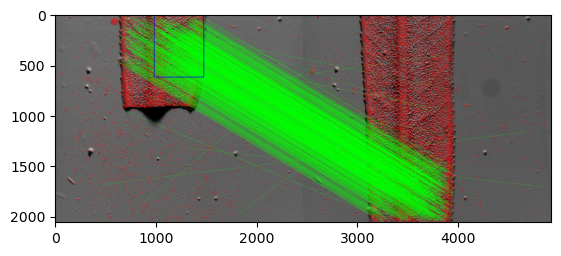

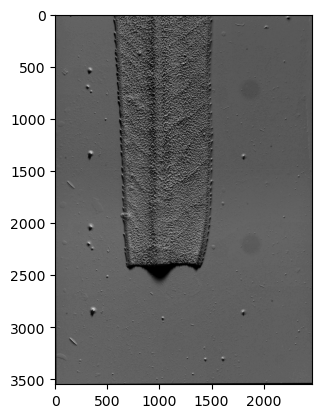

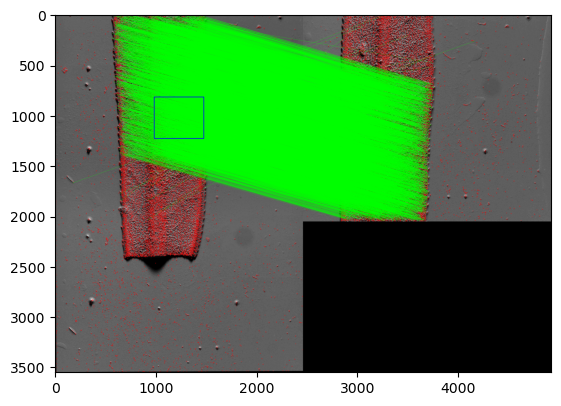

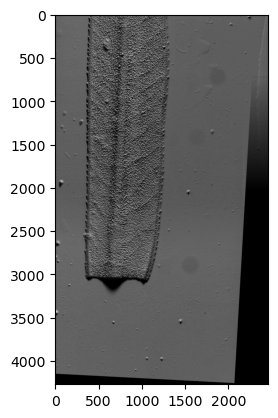

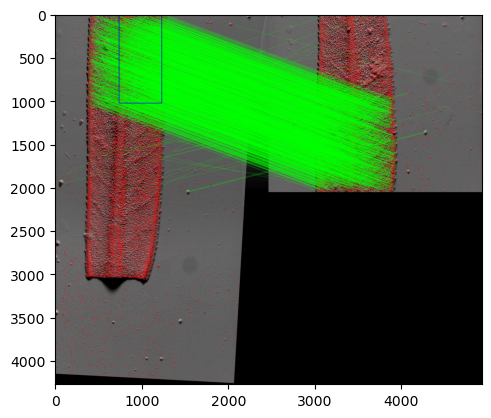

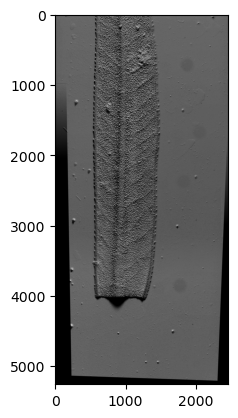

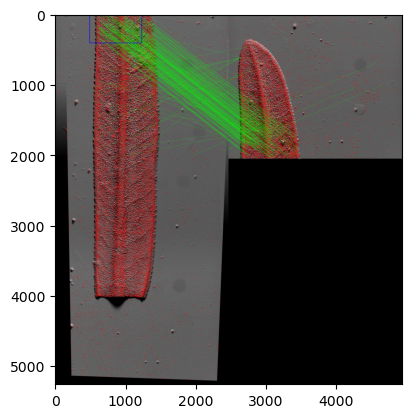

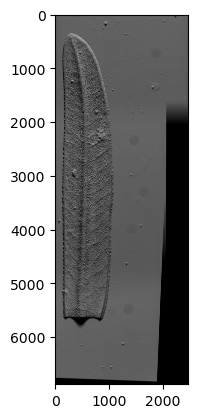

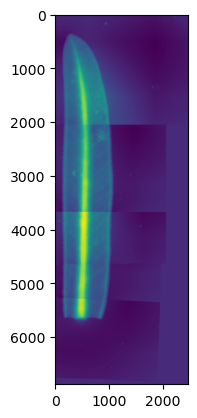

Success


In [37]:
# TODO: warning for bad matches

# input parent directory containing all data and data folder names
parent = './testdata/seagrass120223_processed'
data = ['Leaf2side1_n', 'Leaf2side2_n', 'Leaf3side1_y', 'Leaf3side2_y', 'Leaf4side1_y', 'Leaf4side2_y', 'Leaf5side1_n', 'Leaf5side2_n']
# data = ['groundtruth1_y']
data = ['Leaf2side1_n']
stitchscans(parent,data,diagnose=True,normalize_height=True)

### Running diagnostics

It is also possible to run the stitching function in diagnostic mode, which does not save the output but provides additional information in the form of intermediate steps and matches between consecutive images.

Leaf2side2_n


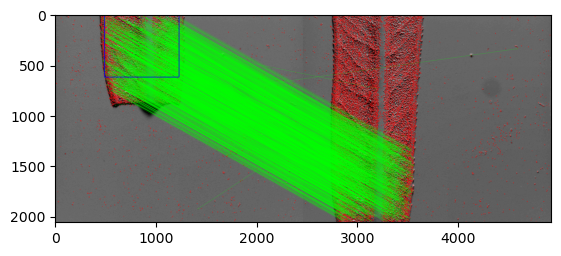

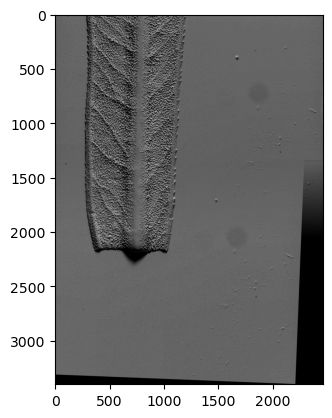

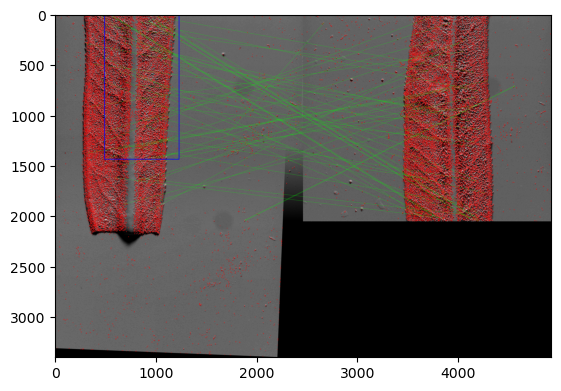

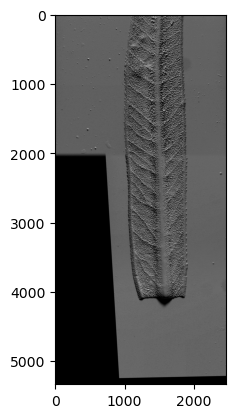

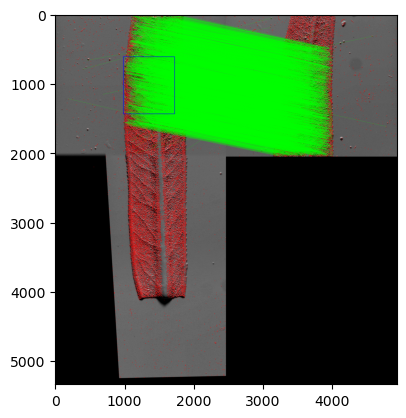

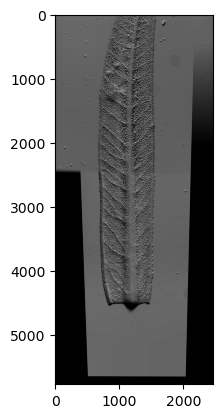

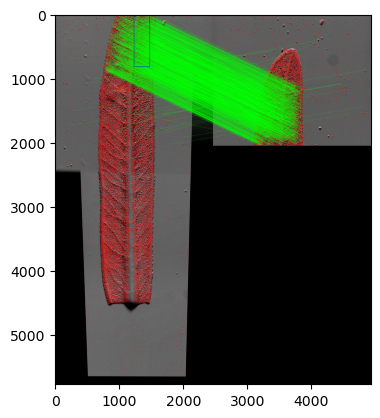

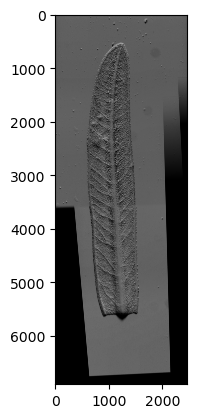

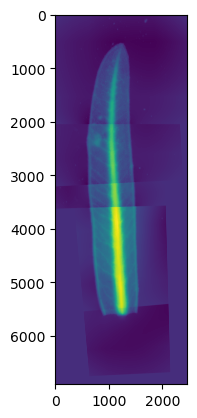

Success


In [81]:
# diagnosing scans that didn't come out well and testing methods
stitchscans('./testdata/seagrass120223_processed',['Leaf2side2_n'],ratio=0.7,levels=0,diagnose=True,mode='sift')

## Compare performance of built-in cv.Stitcher class

During testing, we found that the built-in stitching function was less robust, often failing to match together two consecutive scans. However, the results it returns are typically very accurately matched, with very smooth seams between the images. Note that cv.Stitcher does not require the order of the images to be specified, but it does require specifying either scan or homography mode for the allowed 3D transformations.

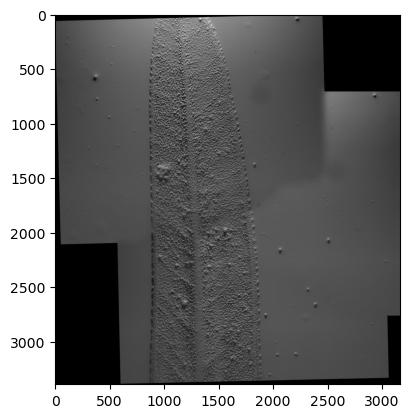

In [177]:
# test built-in stitching function

stitcher = cv.Stitcher.create(mode=cv.Stitcher_SCANS)
status, stitched = stitcher.stitch(ims)
 
if status != cv.Stitcher_OK:
    print("Can't stitch images, error code = %d" % status)
    sys.exit(-1)

plt.clf()
plt.imshow(stitched)
plt.show()

## gsmatlab demo code

Included below for reference

In [ ]:
"""
parentdr = '/Users/deryaakkaynak/Documents/Research_Local/Github/GelSight/gsmatlab/';
spath = fullfile(parentdr,'demo','groove','scan.yaml');
if ~exist(spath,'file')
    error('cannot find scan file for demo %s',spath);
end

hpath = fullfile(parentdr,'demo','groove','heightmap.tmd');
if ~exist(hpath,'file')
    error('cannot find TMD file %s',hpath);
end

sdata = readscan(spath);
lns = getshape(sdata.annotations, [], 'Line1');
if isempty(lns)
    error('cannot find line in scan file');
end
ln = lns{1};

[hm,dt] = readtmd(hpath);
mmpp = dt.mmpp;

% Load first image
im = im2double(imread(sdata.images(1).path));

% Get the profile from the heightmap
p = getprofile(hm, ln, mmpp);

% Level the profile using the spcified regions as the reference
[lp,A] = levelprofile(p, {[0.3 0.9], [3.1 3.6]});

% Dimensions in mm
xd = [1 size(hm,2)]*mmpp;
yd = [1 size(hm,1)]*mmpp;

figure(1)
clf
subplot(131)
imagesc(im,'XData',xd,'YData',yd);
colorbar
axis image 
title('image 1');
xlabel('X (mm)');
ylabel('Y (mm)');
hold on
plotshape('line',ln*mmpp); % Plot units are in mm, multiply by resolution

subplot(132)
imagesc(hm,'XData',xd,'YData',yd);
colorbar
axis image 
title('height (Z)');
xlabel('X (mm)');
ylabel('Y (mm)');
hold on
plotshape('line',ln*mmpp);

zmicrons = lp(2,:)*1000;
subplot(133)
plot(lp(1,:),zmicrons,'b','LineWidth',2);
xlabel('T (mm)');
ylabel(['Z (\mu' 'm)']);
title('Profile along line')
set(gca,'PlotBoxAspectRatio',[3 2 1]);
axis([lp(1,1) lp(1,end) min(zmicrons)-50 max(zmicrons)+50]);
grid on
"""